## Assignment 2:

The goal is to compare `dense neural networks` and `convolutional neural networks` on `Fashion mnist` data.



In all the experiments, we would hold some parameters constants - the batch size to 100, the number of epochs to 20, same optimizer, same loss function of cross entropy, so that we can do fair comparisons. 



* EXPERIMENT 1: DNN with 2 layers (no drop out)

* EXPERIMENT 2: DNN with 3 layers (no drop out)

* EXPERIMENT 3: CNN with 2 convolution/max pooling layers (no drop out)

* EXPERIMENT 4: CNN with 3 convolution/max pooling layers (no drop out)

* **EXPERIMENT 5: Redo all the 4 experiments with 20% drop out**

`Result1`:  Create a table with the accuracy and loss for train/test/validation & process time for all the 8 models

`Result2`: Take `EXPERIMENT 3` – Extract the outputs from 2 selected filters from the 2 max pooling layers and visualize 

## Import packages needed (and set seed)

Since Keras in part of TensorFlow 2.x, we import keras from tensorflow and use tenserflow.keras.xxx to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
keras.__version__

'2.2.4-tf'

In [2]:
tf.__version__

'2.1.0'

In [3]:
# To get consistint results each time we rerun the code.
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## The Fashion MNIST dataset

Zalando is Europe's leading online fashion platform for women, men and children. `Fashion-MNIST` is a dataset of their product images. Just like `MNIST` dataset, the `Fashion-MNIST` also consists of 70,000 grayscale images of 28x28 pixels divided into 60,000 training images and 10,000 test images. Each image is labeled with with an integer from 0 to 9 representing 10 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', respectively. `Fashion-MNIST` is intended to serve as a direct drop-in replacement for the original `MNIST` dataset for benchmarking machine learning algorithms since the the original `MNIST` was found to be too easy for the current machine learning models. In particular, Fashion-Mist shares the same image size and structure of training and testing splits as `MNIST`. Also like `MNIST` it comes prepackaged in `tf.Keras`. Use

```python
fashion_mnist.load_data()
```

to the get these datasets (and the corresponding labels) as Numpy arrays. See the `Fashion-MNIST` GitHub page for a lot more information about the data sets and benchmarks for 129 classifiers trained on the data:

https://github.com/zalandoresearch/fashion-mnist

In [4]:
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images.shape, test_images.shape, test_labels.shape, test_labels.shape

((60000, 28, 28), (10000, 28, 28), (10000,), (10000,))

# EXPERIMENT  1 (with dropout):

The `DNN` model will consist of 784 input nodes, a hidden layer with `5 nodes` followed by a dropout layer and 10 output nodes (corresponding to the 10 fashion categories).

We use `fashion_mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. After training the model, we use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

## Preparing the data

Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the \[0, 1] interval.

Our training images are stored in an array of shape (60000, 28, 28) of type uint8 with values in the [0, 255] interval. 

We transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1.

In [5]:
# We transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1. 

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

## Validating our approach

We set apart 5,000 samples of our training data to use as a validation set. Since we will be using `sparse_categorical_crossentropy` as the loss function we **do not** need to use `to_categorical` to convert the class vector of labels to binary matrix representation.

In [6]:
# Create validation data
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Building our network

Here our network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. Dropout = 20%.

The first `Dense` layer, the hidden layer, consists of `five nodes`.

The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current clothing image belongs to one of our 10 classes.

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(30, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))   # Using softmax instead of sigmoid. Okay?

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                23550     
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
_________________________________________________________________


## Compiling the model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [9]:
model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Creating a callback to get training times

In [10]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

## Training the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [11]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 1s 21us/sample - loss: 0.7834 - accuracy: 0.7353 - val_loss: 0.5051 - val_accuracy: 0.8286
Epoch 2/20
55000/55000 [==============================] - 1s 13us/sample - loss: 0.5323 - accuracy: 0.8131 - val_loss: 0.4302 - val_accuracy: 0.8528
Epoch 3/20
55000/55000 [==============================] - 1s 14us/sample - loss: 0.4876 - accuracy: 0.8297 - val_loss: 0.4091 - val_accuracy: 0.8590
Epoch 4/20
55000/55000 [==============================] - 1s 15us/sample - loss: 0.4604 - accuracy: 0.8372 - val_loss: 0.3994 - val_accuracy: 0.8618
Epoch 5/20
55000/55000 [==============================] - 1s 14us/sample - loss: 0.4420 - accuracy: 0.8434 - val_loss: 0.3866 - val_accuracy: 0.8640
Epoch 6/20
55000/55000 [==============================] - 1s 14us/sample - loss: 0.4333 - accuracy: 0.8452 - val_loss: 0.3754 - val_accuracy: 0.8700
Epoch 7/20
55000/55000 [==============================] -

In [12]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

16.802

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [13]:
# Define callback to get total test time
import datetime

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [14]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])

10000/10000 [==============================] - 0s 33us/sample - loss: 0.3954 - accuracy: 0.8686


In [15]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.326737

## Creating a DataFrame for the training and test statistics

We will create a new DataFrame to hold the training/test times and their accuracy and loss values of the current model. We then "unpickle" the DataFrame from the previous notebook and append the new DataFrame to it. 

The resulting DataFrame will hold the statistics for all the models we have worked with so far.

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [17]:
import pandas as pd
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.377508,0.863291,0.374062,0.8764
16,0.374597,0.863127,0.368521,0.8774
17,0.374406,0.864036,0.367172,0.8796
18,0.371660,0.864964,0.360619,0.8830
19,0.369227,0.865473,0.370008,0.8846


In [18]:
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','DNN (2 layers) w DO') # went the model name to appear first
results_df['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,DNN (2 layers) w DO,0.369227,0.865473,0.370008,0.8846,16.802,0.326737


In [19]:
prev_results_df = pd.read_pickle('results2.pkl')
results_df = prev_results_df.append(results_df,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.479149,0.832018,0.497724,0.8326,14.431099,0.362740
1,DNN (3 layers),0.401199,0.861236,0.411177,0.8638,15.833861,0.402570
2,CNN (2 layers),0.039767,0.986218,0.536305,0.9136,445.142241,1.339899
3,CNN (3 layers),0.078272,0.970455,0.366483,0.9078,431.476962,0.999823
4,DNN (2 layers) w DO,0.369227,0.865473,0.370008,0.8846,16.802000,0.326737


## Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

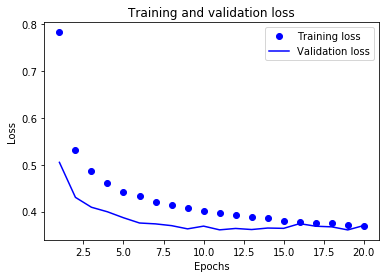

In [20]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

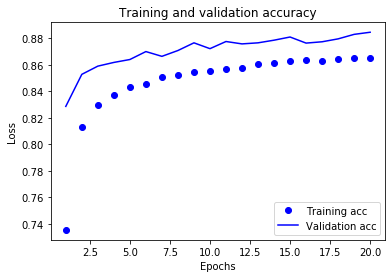

In [21]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# EXPERIMENT  2 (with dropout):

This time our `DNN` model will consist of 784 input nodes, a hidden layer with `10 nodes`, another hidden layer with a hidden layer with `5 nodes` and 10 output nodes (corresponding to the 10 fashion categories). But this time we add a 20% dropout.

We use `fashion_mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. After training the model, we use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [22]:
model = models.Sequential()
model.add(keras.layers.Dense(30, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dropout(0.2))
model.add(keras.layers.Dense(20, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))   # Using softmax instead of sigmoid. Okay?

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 30)                23550     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
Total params: 24,380
Trainable params: 24,380
Non-trainable params: 0
_________________________________________________________________


## Compiling the model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [24]:
model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Training the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [25]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 1s 21us/sample - loss: 0.9604 - accuracy: 0.6593 - val_loss: 0.5171 - val_accuracy: 0.8192
Epoch 2/20
55000/55000 [==============================] - 1s 16us/sample - loss: 0.6242 - accuracy: 0.7761 - val_loss: 0.4401 - val_accuracy: 0.8494
Epoch 3/20
55000/55000 [==============================] - 1s 16us/sample - loss: 0.5639 - accuracy: 0.7984 - val_loss: 0.4301 - val_accuracy: 0.8558
Epoch 4/20
55000/55000 [==============================] - 1s 15us/sample - loss: 0.5345 - accuracy: 0.8113 - val_loss: 0.4026 - val_accuracy: 0.8602
Epoch 5/20
55000/55000 [==============================] - 1s 15us/sample - loss: 0.5120 - accuracy: 0.8197 - val_loss: 0.4086 - val_accuracy: 0.8602
Epoch 6/20
55000/55000 [==============================] - 1s 15us/sample - loss: 0.4953 - accuracy: 0.8260 - val_loss: 0.4010 - val_accuracy: 0.8586
Epoch 7/20
55000/55000 [==============================] -

In [26]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

17.541827

## Testing the model

We are now ready to train our network, which in Keras is done via a call to the `evaluate` method of the network. Also we pass the method the callback object we create to get the total testing time.

In [27]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])

10000/10000 [==============================] - 0s 41us/sample - loss: 0.4216 - accuracy: 0.8611


In [28]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.411977

# Adding the statistics to our results DataFrame

We add the performance statistics for the new model to our DataFrame.

In [29]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
results_df2 = history_df.iloc[-1:].copy()
results_df2.insert(0,'model','DNN (3 layers) w DO') # went the model name to appear first
results_df2['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df2['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df2

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,DNN (3 layers) w DO,0.427804,0.8504,0.391804,0.8712,17.541827,0.411977


In [30]:
results_df

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.479149,0.832018,0.497724,0.8326,14.431099,0.362740
1,DNN (3 layers),0.401199,0.861236,0.411177,0.8638,15.833861,0.402570
2,CNN (2 layers),0.039767,0.986218,0.536305,0.9136,445.142241,1.339899
3,CNN (3 layers),0.078272,0.970455,0.366483,0.9078,431.476962,0.999823
4,DNN (2 layers) w DO,0.369227,0.865473,0.370008,0.8846,16.802000,0.326737


In [31]:
results_df=results_df.append(results_df2,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.479149,0.832018,0.497724,0.8326,14.431099,0.362740
1,DNN (3 layers),0.401199,0.861236,0.411177,0.8638,15.833861,0.402570
2,CNN (2 layers),0.039767,0.986218,0.536305,0.9136,445.142241,1.339899
3,CNN (3 layers),0.078272,0.970455,0.366483,0.9078,431.476962,0.999823
4,DNN (2 layers) w DO,0.369227,0.865473,0.370008,0.8846,16.802000,0.326737
5,DNN (3 layers) w DO,0.427804,0.850400,0.391804,0.8712,17.541827,0.411977


## Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

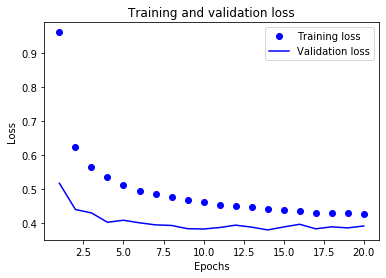

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

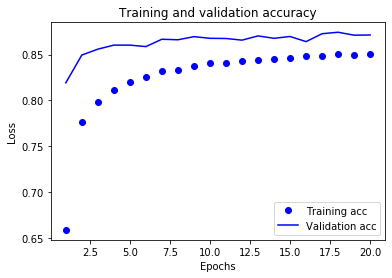

In [33]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## EXPERIMENT 3 (with dropout)

We create a `CNN` with 2 convolution/max pooling layers (with dropout) to work with our Fashion MNIST dataset.

## Preparing the data

Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the \[0, 1] interval.

Our training images are stored in an array of shape (60000, 28, 28) of type uint8 with values in the [0, 255] interval. 

We transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1.


Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the [0, 1] interval.

Currently, our training images are stored in an array of shape (60000, 28, 28). Each image is represented by a 28x28 array of uint8 values in the range [0, 255]. 

We transform it into a float32 array of shape (60000, 28, 28, 1) with values between 0 and 1.

In [34]:
# We transform it into a float32 array of shape (60000, 28, 28, 1) with values between 0 and 1. 
train_images = train_images.reshape((55000, 28, 28, 1))
val_images =val_images.reshape((5000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

## Building our network

We build a `CNN` containing 2 convolutional/max pooling layers. The last layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current clothing image belongs to one of our 10 classes.

In [35]:
# CNN with 2 convolution/max pooling layers AND 20% dropout
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

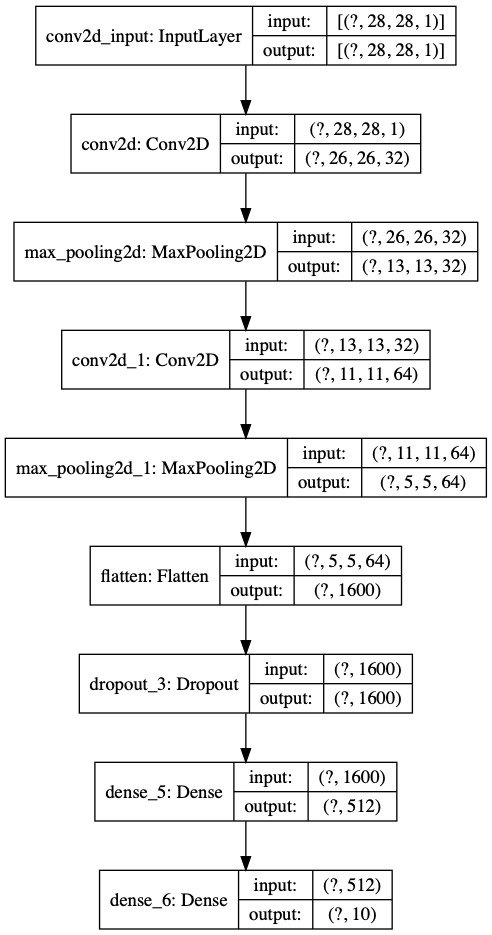

In [36]:
keras.utils.plot_model(model, show_shapes=True)

## Compiling the model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [37]:
# compile the model
model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Training the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [38]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 24s 435us/sample - loss: 0.4959 - accuracy: 0.8179 - val_loss: 0.3419 - val_accuracy: 0.8748
Epoch 2/20
55000/55000 [==============================] - 23s 421us/sample - loss: 0.3242 - accuracy: 0.8804 - val_loss: 0.3011 - val_accuracy: 0.8882
Epoch 3/20
55000/55000 [==============================] - 22s 407us/sample - loss: 0.2770 - accuracy: 0.8984 - val_loss: 0.2457 - val_accuracy: 0.9108
Epoch 4/20
55000/55000 [==============================] - 22s 399us/sample - loss: 0.2466 - accuracy: 0.9084 - val_loss: 0.2462 - val_accuracy: 0.9082
Epoch 5/20
55000/55000 [==============================] - 22s 402us/sample - loss: 0.2255 - accuracy: 0.9173 - val_loss: 0.2397 - val_accuracy: 0.9108
Epoch 6/20
55000/55000 [==============================] - 22s 399us/sample - loss: 0.2070 - accuracy: 0.9230 - val_loss: 0.2229 - val_accuracy: 0.9178
Epoch 7/20
55000/55000 [=====================

In [39]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

465.133279

## Testing the model

We are now ready to train our network, which in Keras is done via a call to the `evaluate` method of the network. Also we pass the method the callback object we create to get the total testing time.

In [40]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])

10000/10000 [==============================] - 1s 137us/sample - loss: 0.3017 - accuracy: 0.9127


In [41]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

1.366865

# Adding the statistics to our results DataFrame

We add the performance statistics for the new model to our DataFrame.

In [42]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [43]:
import pandas as pd
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.112191,0.958182,0.266089,0.9168
16,0.107880,0.959836,0.266972,0.9174
17,0.101067,0.963018,0.262354,0.9270
18,0.096428,0.965273,0.258666,0.9188
19,0.090453,0.966673,0.258823,0.9214


In [44]:
results_df3 = history_df.iloc[-1:].copy()
results_df3.insert(0,'model','CNN (2 layers) w DO') # went the model name to appear first
results_df3['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df3['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df3

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,CNN (2 layers) w DO,0.090453,0.966673,0.258823,0.9214,465.133279,1.366865


In [45]:
results_df = results_df.append(results_df3,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.479149,0.832018,0.497724,0.8326,14.431099,0.362740
1,DNN (3 layers),0.401199,0.861236,0.411177,0.8638,15.833861,0.402570
2,CNN (2 layers),0.039767,0.986218,0.536305,0.9136,445.142241,1.339899
3,CNN (3 layers),0.078272,0.970455,0.366483,0.9078,431.476962,0.999823
4,DNN (2 layers) w DO,0.369227,0.865473,0.370008,0.8846,16.802000,0.326737
5,DNN (3 layers) w DO,0.427804,0.850400,0.391804,0.8712,17.541827,0.411977
6,CNN (2 layers) w DO,0.090453,0.966673,0.258823,0.9214,465.133279,1.366865


## Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

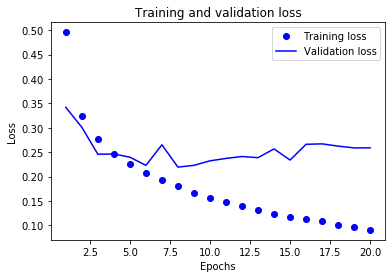

In [46]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

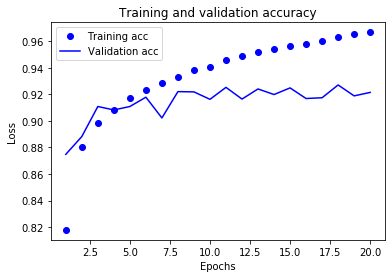

In [47]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## EXPERIMENT 3 (with dropout and data Augmentation)

**TO DO**: Follow the process descrtibed in section 5.25 of Deep Learning with Python by F. Chollet. See 

https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb

## EXPERIMENT 4 (with dropout)

We create a `CNN` with 3 convolution/max pooling layers (with dropout) to work with our Fashion MNIST dataset.

## Building our network

We build a `CNN` containing 2 convolutional/max pooling layers. The last layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current clothing image belongs to one of our 10 classes.

In [49]:
# CNN with 3 convolution/max pooling layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

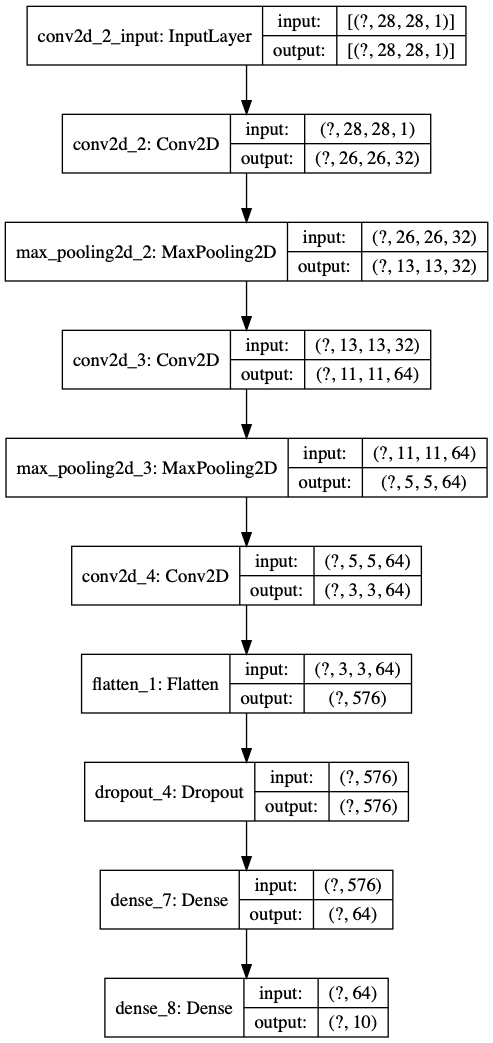

In [50]:
keras.utils.plot_model(model, show_shapes=True)

## Compiling the model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [51]:
model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Training the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [52]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 22s 407us/sample - loss: 0.6122 - accuracy: 0.7724 - val_loss: 0.3951 - val_accuracy: 0.8586
Epoch 2/20
55000/55000 [==============================] - 21s 379us/sample - loss: 0.3775 - accuracy: 0.8603 - val_loss: 0.3313 - val_accuracy: 0.8784
Epoch 3/20
55000/55000 [==============================] - 20s 371us/sample - loss: 0.3198 - accuracy: 0.8831 - val_loss: 0.2762 - val_accuracy: 0.9022
Epoch 4/20
55000/55000 [==============================] - 20s 372us/sample - loss: 0.2842 - accuracy: 0.8955 - val_loss: 0.2765 - val_accuracy: 0.8972
Epoch 5/20
55000/55000 [==============================] - 20s 372us/sample - loss: 0.2619 - accuracy: 0.9028 - val_loss: 0.2613 - val_accuracy: 0.9034
Epoch 6/20
55000/55000 [==============================] - 23s 411us/sample - loss: 0.2436 - accuracy: 0.9109 - val_loss: 0.2413 - val_accuracy: 0.9128
Epoch 7/20
55000/55000 [=====================

In [53]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

434.096894

## Testing the model

We are now ready to train our network, which in Keras is done via a call to the `evaluate` method of the network. Also we pass the method the callback object we create to get the total testing time.

In [54]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])

10000/10000 [==============================] - 1s 106us/sample - loss: 0.2840 - accuracy: 0.9139


In [55]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

1.060402

# Adding the statistics to our results DataFrame

We add the performance statistics for the new model to our DataFrame.

In [56]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [57]:
import pandas as pd
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.144892,0.945727,0.250903,0.9186
16,0.141585,0.946873,0.239556,0.9180
17,0.133797,0.949727,0.253906,0.9216
18,0.131088,0.950818,0.242092,0.9220
19,0.126126,0.953418,0.250766,0.9230


In [58]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
results_df4 = history_df.iloc[-1:].copy()
results_df4.insert(0,'model','CNN (3 layers) with DO') # went the model name to appear first
results_df4['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df4['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df4

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,CNN (3 layers) with DO,0.126126,0.953418,0.250766,0.923,434.096894,1.060402


In [59]:
results_df=results_df.append(results_df4,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.479149,0.832018,0.497724,0.8326,14.431099,0.362740
1,DNN (3 layers),0.401199,0.861236,0.411177,0.8638,15.833861,0.402570
2,CNN (2 layers),0.039767,0.986218,0.536305,0.9136,445.142241,1.339899
3,CNN (3 layers),0.078272,0.970455,0.366483,0.9078,431.476962,0.999823
4,DNN (2 layers) w DO,0.369227,0.865473,0.370008,0.8846,16.802000,0.326737
5,DNN (3 layers) w DO,0.427804,0.850400,0.391804,0.8712,17.541827,0.411977
6,CNN (2 layers) w DO,0.090453,0.966673,0.258823,0.9214,465.133279,1.366865
7,CNN (3 layers) with DO,0.126126,0.953418,0.250766,0.9230,434.096894,1.060402


In [60]:
results_df.to_pickle("results3.pkl") # save the DataFrame for later analysis

## Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

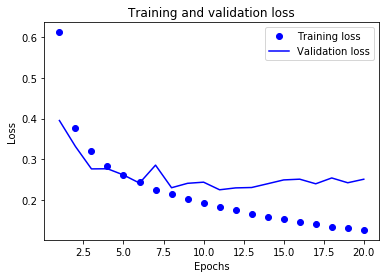

In [61]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

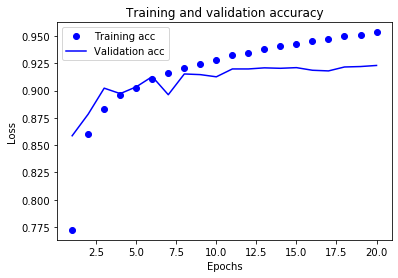

In [62]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()